# PDB Bind: Bonding Affinity and 3D Molecular Structure

Basic Environment:
Python 3.12.12,
rdkit,
sklearn,
xgboost

# 1. Data Loading and Exploration

The PDBbind database provides experimentally measured binding affinities (Kd, Ki, IC₅₀) and 3D structures of protein–ligand complexes. It includes over 14,000 complexes, with 3,700 refined and 195 core high-quality entries.
Since binding affinity reflects molecular interactions—such as hydrogen bonding, hydrophobic, electrostatic, and steric effects—we aim to predict it using ligand and protein features.
Because Kd directly measures binding equilibrium, it is the most relevant target for modeling. To handle its wide numeric range, values are converted to pKd (–log₁₀Kd) for regression. The project begins with the core set for initial training and can later expand to the refined or general sets for broader generalization.

In [9]:
import pandas as pd

file_path = "/Users/jupeiyun/Downloads/v2015/INDEX_refined_data.2015"

# read the refined data file
refined_df = pd.read_csv(
    file_path,
    sep=r"\s+",
    comment="#",       # skip comments (troubleshooting with ChatGPT after pasersing error)
    header=None,
)

print(refined_df.head(10))
print(refined_df.shape)

      0     1     2     3          4   5         6          7
0  2r58  2.00  2007  2.00    Kd=10mM  //  2r58.pdf      (MLY)
1  3c2f  2.35  2008  2.00  Kd=10.1mM  //  3c2f.pdf      (PRP)
2  3g2y  1.31  2009  2.00    Ki=10mM  //  3g2y.pdf      (GF4)
3  3pce  2.06  1998  2.00    Ki=10mM  //  3pce.pdf      (3HP)
4  4qsu  1.90  2014  2.00    Kd=10mM  //  4qsu.pdf      (TDR)
5  4qsv  1.90  2014  2.00    Kd=10mM  //  4qsv.pdf      (THM)
6  1jfh  2.03  1998  2.05     Ki=9mM  //  1jfh.pdf  (MA2-MA3)
7  3ao4  1.95  2011  2.07   Kd=8.5mM  //  3ao1.pdf      (833)
8  4cs9  2.01  2014  2.10     Kd=8mM  //  4cs8.pdf      (AMP)
9  2w8w  2.14  2009  2.12   Kd=7.5mM  //  2w8j.pdf      (PLS)
(3706, 8)


In [12]:
# Name and Selection of Relevant Columns
refined_df.columns = [
    "PDB_ID",       # PDB ID
    "Resolution",   # Crystal resolution in Å
    "Year",         # Publication year
    "pK",           # -log10(Kd/Ki)
    "K",            # (Kd/Ki)
    "NA",        # Random line
    "Reference",    # file name
    "Ligand_Name"   # Ligand name
]

refined_df_abbv = refined_df[["PDB_ID","pK", "K", "Reference", "Ligand_Name"]]
print(refined_df_abbv.head(10))

  PDB_ID    pK          K Reference Ligand_Name
0   2r58  2.00    Kd=10mM  2r58.pdf       (MLY)
1   3c2f  2.00  Kd=10.1mM  3c2f.pdf       (PRP)
2   3g2y  2.00    Ki=10mM  3g2y.pdf       (GF4)
3   3pce  2.00    Ki=10mM  3pce.pdf       (3HP)
4   4qsu  2.00    Kd=10mM  4qsu.pdf       (TDR)
5   4qsv  2.00    Kd=10mM  4qsv.pdf       (THM)
6   1jfh  2.05     Ki=9mM  1jfh.pdf   (MA2-MA3)
7   3ao4  2.07   Kd=8.5mM  3ao1.pdf       (833)
8   4cs9  2.10     Kd=8mM  4cs8.pdf       (AMP)
9   2w8w  2.12   Kd=7.5mM  2w8j.pdf       (PLS)


# 2. Data Loading and Exploration

Using RDKit, we converted the PDB files into numerical descriptors, as RDKit enables the extraction of various chemical properties from both 2D and 3D molecular structures. We selected several key chemically relevant features, including the number of hydrogen bond acceptors and donors, hydrophobic interactions, molecular weight (MolWt), topological polar surface area (TPSA), and the number of rotatable bonds. These molecular descriptors were analyzed alongside the protein ID (PID), binding constant (Kd or Ki), and its logarithmic form (pKd).

To generate numerical values for regression, I asked Chatgpt "how to explore pdb files into numberical chemical properties for regression?", it suggested the RDKit and I did my research on (https://www.rdkit.org/docs/GettingStartedInPython.html#drawing-chemical-reactions) and find the "Descriptor Calculation" section with below parameters for use

In [13]:
from rdkit import Chem, RDLogger
from rdkit.Chem import Descriptors
import pandas as pd
import os

directory = "/Users/jupeiyun/Downloads/v2015/"

# Suppress RDKit warnings after it claim that Z is not zero and 3D is mistakenly treated as 2D, which ChatGPT suggested is not the case
RDLogger.DisableLog('rdApp.*')

# Function to get mol12 file
def file_pathway(pdb_id):
    mol2_path = os.path.join(directory, pdb_id, f"{pdb_id}_ligand.mol2")
    if os.path.exists(mol2_path):
        return mol2_path
    return None

descriptor_list = [
    "MolWt",            # Molecular Weight
    "MolLogP",          # Hydrophobicity (LogP)
    "TPSA",             # Polar Surface Area
    "NumHDonors",       # Number of Hydrogen Donors
    "NumHAcceptors",    # Number of Hydrogen Acceptors
    "NumRotatableBonds" # Number of Rotatable Bonds
    ]

# Compute descriptors for each molecule
descriptor_rows = []

for pdb_id in refined_df_abbv["PDB_ID"]:
#ChatGPT suggested to avoid damaged data to handle errors during molecule processing
    try:
        mol = Chem.SDMolSupplier(
            os.path.join(directory, pdb_id, f"{pdb_id}_ligand.sdf"), 
            sanitize=False
        )[0]
        if mol is None:
            mol = Chem.MolFromMolFile(
                os.path.join(directory, pdb_id, f"{pdb_id}_ligand.mol2"), 
                sanitize=False, removeHs=False
            )
        Chem.SanitizeMol(mol, catchErrors=True)
        descriptor = [Descriptors.__dict__[d](mol) for d in descriptor_list]
        descriptor_rows.append([pdb_id] + descriptor)
    except Exception:
        # Just skip any molecule RDKit cannot process
        continue

# Create DataFrame
descriptor_df = pd.DataFrame(descriptor_rows, columns=["PDB_ID"] + descriptor_list)

# Merge dataframes
Regression_df = pd.merge(refined_df_abbv, descriptor_df, on="PDB_ID")

# Display
print(Regression_df.head())
print(Regression_df.shape)

  PDB_ID    pK         K Reference Ligand_Name    MolWt  MolLogP    TPSA  \
0   3g2y  2.00   Ki=10mM  3g2y.pdf       (GF4)  194.198 -0.45048   92.25   
1   4qsu  2.00   Kd=10mM  4qsu.pdf       (TDR)  126.115 -0.05690   58.53   
2   4qsv  2.00   Kd=10mM  4qsv.pdf       (THM)  242.231 -1.51428  104.55   
3   1jfh  2.05    Ki=9mM  1jfh.pdf   (MA2-MA3)  402.487 -2.65580  149.07   
4   3ao4  2.07  Kd=8.5mM  3ao1.pdf       (833)  217.228  0.61964   62.30   

   NumHDonors  NumHAcceptors  NumRotatableBonds  
0           2              5                  4  
1           1              2                  1  
2           3              6                  5  
3           6             11                 14  
4           1              5                  3  
(1994, 11)


# 3. Random Forest Regression

We implemented a Random Forest Regressor to predict binding affinity (pK) using selected molecular descriptors as input features, including molecular weight (MolWt), lipophilicity (MolLogP), topological polar surface area (TPSA), and the number of hydrogen bond donors, acceptors, and rotatable bonds. The dataset was divided into training, validation, and testing sets with dimensions (1276, 6), (319, 6), and (399, 6), respectively. To achieve optimal performance, we employed Optuna for hyperparameter tuning and identified the best combination of model parameters. Once the optimal model was obtained, we analyzed feature importance to determine which molecular descriptors contributed most strongly to binding affinity prediction. Finally, we retrained the model using only the most potent feature to evaluate how well a single descriptor could predict pK compared to the full-feature model.

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import optuna
from sklearn.model_selection import cross_val_score

X = Regression_df[["MolWt", "MolLogP", "TPSA", "NumHDonors", "NumHAcceptors", "NumRotatableBonds"]]
y = Regression_df["pK"]

# Split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

np.random.seed(42)
X = pd.DataFrame(np.random.rand(refined_df.shape[0], 100), columns=[f"feat_{i}" for i in range(100)])
y = refined_df["pK"].astype(float)

# Random Forest regressor (acquisition: https://optuna.readthedocs.io/en/stable)
def Regression_model(trial):
    return RandomForestRegressor(
    n_estimators=trial.suggest_int('n_estimators', 50, 1000),               #generally more trees better performance but papers suggesting 500 is more than sufficient especially with a smaller dataset
    max_depth=trial.suggest_int('max_depth', 3, 40),                        #generally deeper trees better performance but risk of overfitting
    min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
    min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 5),           #to prevent overfitting on small datasets
    max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2']),
    bootstrap=trial.suggest_categorical('bootstrap', [True, False]),
    random_state=42,
    n_jobs=-1
    )


def objective(trial):
    model = Regression_model(trial)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
    return np.mean(score)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)


print("\nBest hyperparameters:")
print(study.best_params)

def objective(trial):
    model = Regression_model(trial)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
    return np.mean(score)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best hyperparameters:")
print(study.best_params)


[I 2025-10-24 11:14:55,650] A new study created in memory with name: no-name-d2053861-83ba-457b-a505-6d226a445077


Train: (1276, 6), Validation: (319, 6), Test: (399, 6)


[I 2025-10-24 11:14:57,641] Trial 0 finished with value: 0.41505231109241914 and parameters: {'n_estimators': 268, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.41505231109241914.
[I 2025-10-24 11:14:59,105] Trial 1 finished with value: 0.42406112552377523 and parameters: {'n_estimators': 232, 'max_depth': 31, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.42406112552377523.
[I 2025-10-24 11:14:59,341] Trial 2 finished with value: 0.4203815200600724 and parameters: {'n_estimators': 225, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.42406112552377523.
[I 2025-10-24 11:15:00,806] Trial 3 finished with value: 0.38255661041097205 and parameters: {'n_estimators': 636, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_f


Best hyperparameters:
{'n_estimators': 573, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}


[I 2025-10-24 11:15:28,028] Trial 0 finished with value: 0.38112627791431813 and parameters: {'n_estimators': 854, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.38112627791431813.
[I 2025-10-24 11:15:28,151] Trial 1 finished with value: 0.40438831294473054 and parameters: {'n_estimators': 110, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.40438831294473054.
[I 2025-10-24 11:15:28,451] Trial 2 finished with value: 0.4156955870625058 and parameters: {'n_estimators': 307, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 2 with value: 0.4156955870625058.
[I 2025-10-24 11:15:29,144] Trial 3 finished with value: 0.4173791320408561 and parameters: {'n_estimators': 740, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_fea

Best hyperparameters:
{'n_estimators': 413, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}


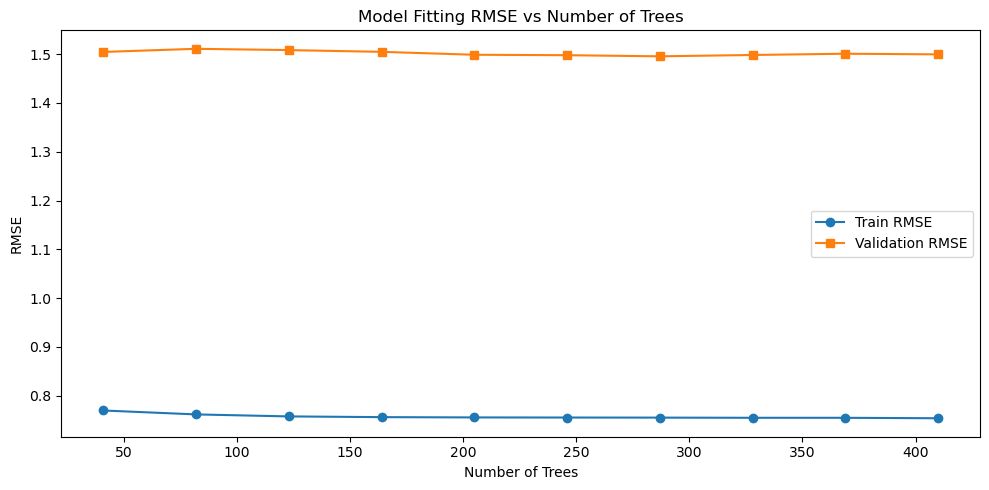

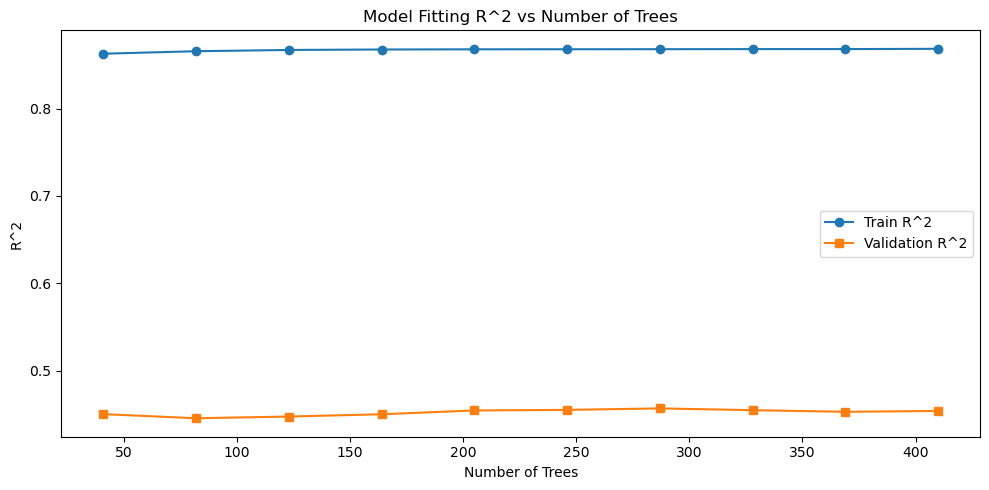

In [ ]:
import matplotlib.pyplot as plt

best_params = study.best_params
best_model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)


# Fit model on training data and record validation performance as the number of trees increases and model matures
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

train_rmse, val_rmse = [], []
train_r2, val_r2 = [], []

n_estimators = best_params['n_estimators']
step = max(10, n_estimators // 10)

for n in range(step, n_estimators + 1, step):
    model_partial = RandomForestRegressor(**{**best_params, 'n_estimators': n}, random_state=42, n_jobs=-1)
    model_partial.fit(X_train, y_train)
    y_train_pred = model_partial.predict(X_train)
    y_val_pred = model_partial.predict(X_val)
    # rmse calculation
    train_rmse.append(rmse(y_train, y_train_pred))
    val_rmse.append(rmse(y_val, y_val_pred))
    # r2 calculation
    train_r2.append(r2_score(y_train, y_train_pred))
    val_r2.append(r2_score(y_val, y_val_pred))

iters = list(range(step, n_estimators + 1, step))
plt.figure(figsize=(10,5))
plt.plot(iters, train_rmse, label='Train RMSE', marker='o')
plt.plot(iters, val_rmse, label='Validation RMSE', marker='s')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.title('Model Fitting RMSE vs Number of Trees')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(iters, train_r2, label='Train R^2', marker='o')
plt.plot(iters, val_r2, label='Validation R^2', marker='s')
plt.xlabel('Number of Trees')
plt.ylabel('R^2')
plt.title('Model Fitting R^2 vs Number of Trees')
plt.legend()
plt.tight_layout()
plt.show()

In [52]:
best_params = study.best_params
final_model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
final_model.fit(X_train_full, y_train_full)

y_pred_test = final_model.predict(X_test)

r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"Final Test Results: R² = {r2_test:.3f}, RMSE = {rmse_test:.3f}")

Final Test Results: R² = 0.496, RMSE = 1.445


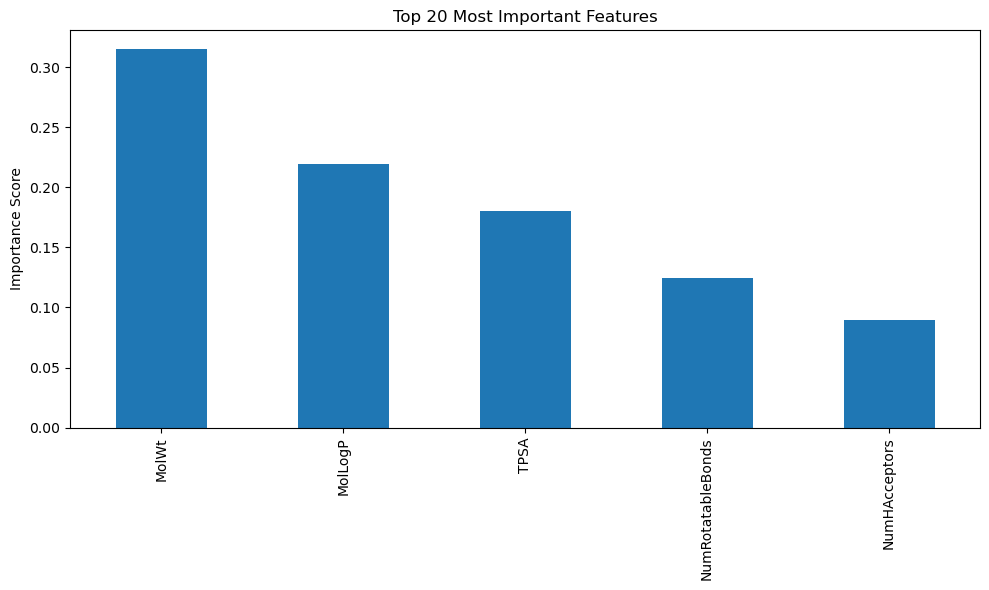

In [53]:
importances = pd.Series(final_model.feature_importances_, index=X_train.columns)
sorted_importances = importances.sort_values(ascending=False)

# Display top 5
top_features = sorted_importances.head(5)
plt.figure(figsize=(10,6))
top_features.plot(kind='bar')
plt.title("Top 20 Most Important Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()


In [54]:
# MolWt-only model as MolWt is the most important feature
X_best = Regression_df[["MolWt"]]
y = Regression_df["pK"].astype(float)

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_best, y, test_size=0.2, random_state=42)

molwt_model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
molwt_model.fit(X_train_m, y_train_m)

y_pred_m = molwt_model.predict(X_test_m)
r2_m = r2_score(y_test_m, y_pred_m)
rmse_m = np.sqrt(mean_squared_error(y_test_m, y_pred_m))

print(f"Best Parameter - MolWt Model → R² = {r2_m:.3f}, RMSE = {rmse_m:.3f}")

Best Parameter - MolWt Model → R² = 0.247, RMSE = 1.767


Train RMSE: 0.746, Validation RMSE: 1.506, Test RMSE: 1.491
Train R²: 0.871, Validation R²: 0.458, Test R²: 0.464


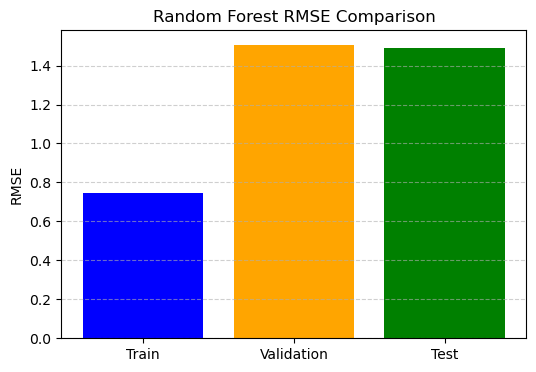

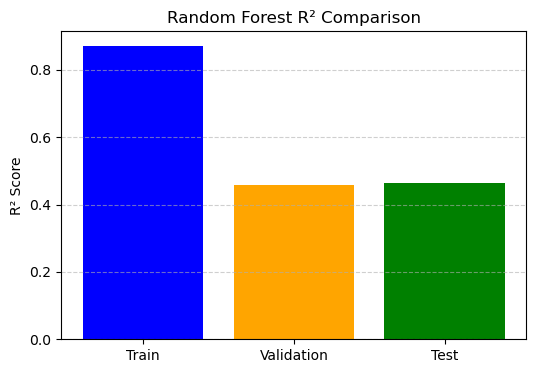

In [62]:
from sklearn.model_selection import train_test_split

rf = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predict
y_pred_train = rf.predict(X_train)
y_pred_val = rf.predict(X_val)
y_pred_test = rf.predict(X_test)

# Compute metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

train_r2 = r2_score(y_train, y_pred_train)
val_r2 = r2_score(y_val, y_pred_val)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {train_rmse:.3f}, Validation RMSE: {val_rmse:.3f}, Test RMSE: {test_rmse:.3f}")
print(f"Train R²: {train_r2:.3f}, Validation R²: {val_r2:.3f}, Test R²: {test_r2:.3f}")

# RMSE comparison
plt.figure(figsize=(6,4))
plt.bar(['Train', 'Validation', 'Test'], [train_rmse, val_rmse, test_rmse], color=['blue', 'orange', 'green'])
plt.ylabel("RMSE")
plt.title("Random Forest RMSE Comparison")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

# R² comparison
plt.figure(figsize=(6,4))
plt.bar(['Train', 'Validation', 'Test'], [train_r2, val_r2, test_r2], color=['blue', 'orange', 'green'])
plt.ylabel("R² Score")
plt.title("Random Forest R² Comparison")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()


# 4. Model Comparison

Initially, we planned to perform a detailed comparison between the Random Forest Regressor and the Gradient Boosting Regressor to evaluate their predictive performance on binding affinity. However, during hyperparameter optimization, both models yielded comparable results, showing no significant difference in accuracy or error metrics. Given the similarity in performance, we decided to explore a more advanced deep learning approach by implementing a two-layer Graph Convolutional Network (GCN) Regressor.

The motivation for this shift stemmed from the desire to incorporate molecular graph structures directly into the model, enabling it to capture atomic connectivity and spatial relationships that traditional feature-based models cannot fully represent. This decision was further supported by findings from the MoleculeNet benchmark study (Zhenqin Wu et al., Chemical Science, 2018), which reported that graph-based models such as GraphConv significantly outperformed traditional machine learning algorithms on similar PDBBind binding affinity prediction tasks—achieving an R^2 of approximately 0.49 and an RMSE of around 1.3, compared to 0.27 and 1.5 for Random Forests. These insights encouraged us to adopt a GCN-based approach to better model molecular interactions and improve prediction accuracy.



In [57]:
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

Regression_df = Regression_df.dropna(subset=["pK", "MolWt", "MolLogP", "TPSA", "NumHDonors", "NumHAcceptors", "NumRotatableBonds"])

X = Regression_df[["MolWt", "MolLogP", "TPSA", "NumHDonors", "NumHAcceptors", "NumRotatableBonds"]]
y = Regression_df["pK"].astype(float)

X_train_gb, X_test_gb, y_train_gb, y_test_gb = train_test_split(X, y, test_size=0.2, random_state=42)

def XGB_model(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1, log=True),  # (Source: https://doi.org/10.3390/min12121621)
        "max_depth": trial.suggest_int("max_depth", 2, 8),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "random_state": 42,
    }
    
    model = GradientBoostingRegressor(**params)
    score = cross_val_score(model, X_train_gb, y_train_gb, cv=5, scoring="r2", n_jobs=-1)
    return np.mean(score)

study_gb = optuna.create_study(direction="maximize")
study_gb.optimize(objective, n_trials=50)

print("Best hyperparameters for Gradient Boosting:")
print(study_gb.best_params)


[I 2025-10-24 11:22:16,948] A new study created in memory with name: no-name-36ff2200-319a-4a02-9c64-6a1fb4c0b9de
[I 2025-10-24 11:22:19,182] Trial 0 finished with value: 0.40731259966729605 and parameters: {'n_estimators': 575, 'max_depth': 26, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.40731259966729605.
[I 2025-10-24 11:22:20,739] Trial 1 finished with value: 0.4175428703637004 and parameters: {'n_estimators': 616, 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.4175428703637004.
[I 2025-10-24 11:22:22,106] Trial 2 finished with value: 0.41758951197812183 and parameters: {'n_estimators': 205, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 2 with value: 0.41758951197812183.
[I 2025-10-24 11:22:22,868] Trial 3 finished with value: 0.41220679580

Best hyperparameters for Gradient Boosting:
{'n_estimators': 778, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}


# 5. Continuation of GCN with Google Colab due to Environment Setup and Compatibility

The implementation of the Graph Convolutional Network (GCN) was carried out on Google Colab, as several essential deep learning packages required for the model were incompatible with Apple Silicon architecture. During setup, multiple Python versions (3.8, 3.11, and 3.12) were tested but resulted in persistent dependency and compatibility issues, particularly with libraries such as PyTorch and DeepChem. After iterative troubleshooting, the environment was successfully stabilized using Python 3.9, which provided the best balance between compatibility and functionality, allowing the GCN workflow to run smoothly with only minor compromises.